In [1]:
#Importing the dataset

#Note:::: Change output column names to "RealOrFake" and "PositiveOrNegative" before uploading
import pandas as pd
urgencyDf = pd.read_csv("UrgencyDetectionDataset.csv")

In [2]:
from sklearn.model_selection import train_test_split
SEED = 50
def split_dataset(X, y, test_size):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y, shuffle=True)

  #Re-indexing
  X_train = pd.Series(X_train.values.tolist())
  X_test = pd.Series(X_test.values.tolist())
  y_train = pd.Series(y_train.values.tolist())
  y_test = pd.Series(y_test.values.tolist())

  return [X_train, X_test, y_train, y_test]

In [3]:
features_df = urgencyDf.drop(['id', 'keyword', 'location', 'target'], axis = 1)
features_df.insert(len(features_df.columns), 'target', urgencyDf['target'])

urgencyDf = features_df

In [4]:
urgencyDf

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


#Split the Dataset


In [5]:
#Test-Train Split with Equal Positive and Negative Reviews
X = urgencyDf['text']
y = urgencyDf['target']

[X_train, X_test, y_train, y_test] = split_dataset(X, y, 0.2)

#Metrics

In [6]:
!pip install datasets
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 15.4 MB/s 
     |████████████████████████████████| 212 kB 56.9 MB/s 
     |████████████████████████████████| 115 kB 58.2 MB/s 
     |████████████████████████████████| 182 kB 47.0 MB/s 
     |████████████████████████████████| 127 kB 57.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [7]:
!pip install -q transformers
!pip install sentence_transformers

     |████████████████████████████████| 5.5 MB 8.9 MB/s 
     |████████████████████████████████| 7.6 MB 38.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.2 MB/s 
     |████████████████████████████████| 1.3 MB 40.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=77c791ba60e0d8be0a0f2fc7b949f52a0f5df78bb3f12d53dc9d5d5a15b6377b
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [8]:
## Train Dataset with labels
import torch
from torch.utils.data import Dataset

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

## Test Dataset without labels
class SentimentTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item
    def __len__(self):
        return len(self.encodings)

#Model Training

In [9]:
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback

def train(pretrainedTokenizerName, modelName, trainedModelOutputDir, X, y):
  [X_train_data, X_test_data, y_train_data, y_val_data] = split_dataset(X, y, 0.2)
  
  tokenizer = AutoTokenizer.from_pretrained(pretrainedTokenizerName)
  tokenizer.add_special_tokens({'pad_token': '[PAD]'}) 
  #specific_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")
  tokenized_train = tokenizer(X_train_data.values.tolist(), truncation=True, padding=True, return_tensors='pt')
  tokenized_test = tokenizer(X_test_data.values.tolist(), truncation=True, padding=True, return_tensors='pt')

  print(tokenized_train)
  print(tokenized_test)

  train_dataset = SentimentDataset(tokenized_train, y_train_data)
  test_dataset = SentimentDataset(tokenized_test, y_val_data)
  
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  model = AutoModelForSequenceClassification.from_pretrained(modelName, num_labels=2)

  training_args = TrainingArguments(
    output_dir=trainedModelOutputDir,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # num_train_epochs=2,
    evaluation_strategy = 'steps',
    eval_steps = 50,
    metric_for_best_model = 'f1',
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_strategy = "steps",
    push_to_hub=False
  )
  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],
    compute_metrics=compute_metrics
  )

  trainer.train()
  trainer.evaluate()

  return trainer

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
import matplotlib.pyplot as plt

def predict_and_calculate_score(pretrainedTokenizerName, trainer, X_test, y_test):
  tokenizer = AutoTokenizer.from_pretrained(pretrainedTokenizerName)
  tokenized_test = tokenizer( X_test.values.tolist(), truncation=True, padding=True,return_tensors = 'pt')

  test_dataset = SentimentDataset(tokenized_test, y_test)
  preds = trainer.predict(test_dataset=test_dataset)
  probs = torch.from_numpy(preds[0]).softmax(1)
  y_preds = probs.numpy()# convert tensors to numpy array
  y_preds = np.argmax(y_preds,axis=1)
  accuracy = accuracy_score(y_test, y_preds)
  f1 = f1_score(y_test, y_preds, average='macro')

  #Confusion Matrix
  confusion_matrix = metrics.confusion_matrix(y_test, y_preds)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
  cm_display.plot()
  plt.show()

  return {"accuracy": accuracy, "f1": f1}

#Fine tune pre-trained models

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': tensor([[ 101, 1012, 1030,  ...,    0,    0,    0],
        [ 101, 1012, 1030,  ...,    0,    0,    0],
        [ 101, 1030, 3376,  ...,    0,    0,    0],
        ...,
        [ 101, 4911, 2739,  ...,    0,    0,    0],
        [ 101, 2008, 2165,  ...,    0,    0,    0],
        [ 101, 2065, 2009,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
{'input_ids': tensor([[  101, 10611,  3012,  ...,     0,     0,     0],
        [  101, 10089,  2886,  ...,     0,     0,     0],
        [  101,  1030,  1035,  ...,     0,     0,     0

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Step,Training Loss,Validation Loss,Accuracy,F1
50,No log,0.464487,0.794745,0.731760
100,No log,0.434441,0.824302,0.795411
150,No log,0.436118,0.829228,0.805243
200,No log,0.430584,0.825123,0.794600
250,No log,0.408269,0.839901,0.803625
300,No log,0.399977,0.834975,0.798395
350,No log,0.430706,0.832512,0.791837
400,No log,0.431443,0.830870,0.791498
450,No log,0.421901,0.829228,0.797271
500,0.400600,0.456449,0.833333,0.804995


***** Running Evaluation *****
  Num examples = 1218
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
***** Running Evaluation *****
  Num examples = 1218
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
***** Running Evaluation *****
  Num examples = 1218
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True),

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file to

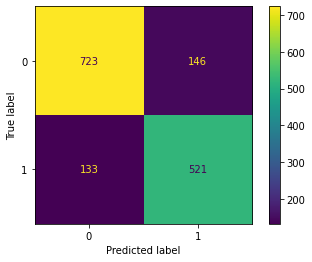

{'accuracy': 0.8168089297439265, 'f1': 0.8135286179771584}

In [ ]:
trainer_bert = train("bert-base-uncased", "bert-base-uncased", "trained_sentiment_bert", X_train, y_train)
preds_bert = predict_and_calculate_score("bert-base-uncased", trainer_bert, X_test, y_test)
preds_bert

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/586 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--juliensimon--reviews-sentiment-analysis/snapshots/7086631c39dcbb051d17ad01d07d747073383882/config.json
Model config DistilBertConfig {
  "_name_or_path": "juliensimon/reviews-sentiment-analysis",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--juliensimon--reviews-sentiment-analysis/snapshots/7086631c39dcbb051d17ad01d07d747073383882/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--juliensimon--reviews-sentiment-analysis/snapshots/7086631c39dcbb051d17ad01d07d747073383882/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--juliensimon--reviews-sentiment-analysis/snapshots/7086631c39dcbb051d17ad01d07d747073383882/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--juliensimon--reviews-sentiment-analysis/snapshots/7086631c39dcbb051d17ad01d07d747073383882/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--juliensimon--reviews-sentiment-analysis/snapshots/7086631c39dcbb051d17ad01d07d747073383882/config.

{'input_ids': tensor([[ 101, 1012, 1030,  ...,    0,    0,    0],
        [ 101, 1012, 1030,  ...,    0,    0,    0],
        [ 101, 1030, 3376,  ...,    0,    0,    0],
        ...,
        [ 101, 4911, 2739,  ...,    0,    0,    0],
        [ 101, 2008, 2165,  ...,    0,    0,    0],
        [ 101, 2065, 2009,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
{'input_ids': tensor([[  101, 10611,  3012,  ...,     0,     0,     0],
        [  101, 10089,  2886,  ...,     0,     0,     0],
        [  101,  1030,  1035,  ...,     0,     0,     0],
        ...,
        [  101,  2417, 23194,  ...,     0,     0,     0],
        [  101,  1030, 18712,  ...,     0,     0,     0],
        [  101,  1030,  2128,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--juliensimon--reviews-sentiment-analysis/snapshots/7086631c39dcbb051d17ad01d07d747073383882/config.json
Model config DistilBertConfig {
  "_name_or_path": "juliensimon/reviews-sentiment-analysis",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--juliensimon--reviews-sentiment-analysis/snapshots/7086631c39dcbb051d17ad01d07d747073383882/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at juliensimon/reviews-sentiment-analysis.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: Thi

Step,Training Loss,Validation Loss,Accuracy,F1
50,No log,0.555730,0.724959,0.682464
100,No log,0.491560,0.786535,0.768271
150,No log,0.427460,0.821839,0.784080
200,No log,0.428399,0.825123,0.791789
250,No log,0.407407,0.834154,0.796781
300,No log,0.403686,0.819376,0.760349
350,No log,0.420642,0.834154,0.794297
400,No log,0.414472,0.830049,0.780021
450,No log,0.426468,0.833333,0.798811
500,0.412700,0.422412,0.839901,0.804413


***** Running Evaluation *****
  Num examples = 1218
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
***** Running Evaluation *****
  Num examples = 1218
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
***** Running Evaluation *****
  Num examples = 1218
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--juliensimon--reviews-sentiment-analysis/snapshots/7086631c39dcbb051d17ad01d07d747073383882/config.json
Model config DistilBertConfig {
  "_name_or_path": "juliensimon/reviews-sentiment-analysis",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--juliensimon--reviews-sentiment-analysis/snapshots/7086631c39dcbb051d17ad01d07d747073383882/vocab.txt

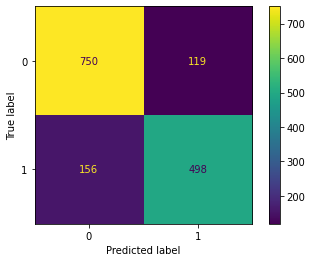

{'accuracy': 0.8194353250164149, 'f1': 0.814352677829368}

In [ ]:
trainer_review_sentiment = train("juliensimon/reviews-sentiment-analysis", "juliensimon/reviews-sentiment-analysis", "trained_sentiment_bert", X_train, y_train)
preds_review_sentiment = predict_and_calculate_score("juliensimon/reviews-sentiment-analysis", trainer_review_sentiment, X_test, y_test)
preds_review_sentiment

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropo

{'input_ids': tensor([[ 101, 1012, 1030,  ...,    0,    0,    0],
        [ 101, 1012, 1030,  ...,    0,    0,    0],
        [ 101, 1030, 3376,  ...,    0,    0,    0],
        ...,
        [ 101, 4911, 2739,  ...,    0,    0,    0],
        [ 101, 2008, 2165,  ...,    0,    0,    0],
        [ 101, 2065, 2009,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
{'input_ids': tensor([[  101, 10611,  3012,  ...,     0,     0,     0],
        [  101, 10089,  2886,  ...,     0,     0,     0],
        [  101,  1030,  1035,  ...,     0,     0,     0],
        ...,
        [  101,  2417, 23194,  ...,     0,     0,     0],
        [  101,  1030, 18712,  ...,     0,     0,     0],
        [  101,  1030,  2128,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBert

Step,Training Loss,Validation Loss,Accuracy,F1
50,No log,0.458350,0.802135,0.754832
100,No log,0.465272,0.794745,0.775986
150,No log,0.406592,0.827586,0.796512
200,No log,0.412446,0.830049,0.800770
250,No log,0.395141,0.837438,0.807767
300,No log,0.392443,0.833333,0.791367
350,No log,0.403549,0.832512,0.788382
400,No log,0.427267,0.826765,0.773848
450,No log,0.404261,0.839901,0.811958
500,0.397400,0.415231,0.832512,0.788820


***** Running Evaluation *****
  Num examples = 1218
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
***** Running Evaluation *****
  Num examples = 1218
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
***** Running Evaluation *****
  Num examples = 1218
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

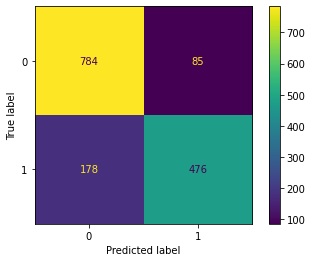

{'accuracy': 0.8273145108338805, 'f1': 0.8199508690072439}

In [ ]:
trainer_distil_bert = train("distilbert-base-uncased", "distilbert-base-uncased", "trained_sentiment_bert", X_train, y_train)
preds_distil_bert = predict_and_calculate_score("distilbert-base-uncased", trainer_distil_bert, X_test, y_test)
preds_distil_bert

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/464 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nghuyong--ernie-2.0-base-en/snapshots/2c22755178879588695a30d68a4d9e861237db7b/config.json
Model config ErnieConfig {
  "_name_or_path": "nghuyong/ernie-2.0-base-en",
  "architectures": [
    "ErnieModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 512,
  "model_type": "ernie",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "task_type_vocab_size": 3,
  "transformers_version": "4.24.0",
  "type_vocab_size": 4,
  "use_cache": true,
  "use_task_id": false,
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--nghuyong--ernie-2.0-base-en/snapshots/2c22755178879588695a30d68a4d9e861237db7b/vocab.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--nghuyong--ernie-2.0-base-en/snapshots/2c22755178879588695a30d68a4d9e861237db7b/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--nghuyong--ernie-2.0-base-en/snapshots/2c22755178879588695a30d68a4d9e861237db7b/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nghuyong--ernie-2.0-base-en/snapshots/2c22755178879588695a30d68a4d9e861237db7b/config.json
Model config ErnieConfig {
  "_name_or_path": "nghuyong/ernie-2.0-base-en",
  "architectures": [
    "ErnieModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout":

{'input_ids': tensor([[ 101, 1012, 1030,  ...,    0,    0,    0],
        [ 101, 1012, 1030,  ...,    0,    0,    0],
        [ 101, 1030, 3376,  ...,    0,    0,    0],
        ...,
        [ 101, 4911, 2739,  ...,    0,    0,    0],
        [ 101, 2008, 2165,  ...,    0,    0,    0],
        [ 101, 2065, 2009,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
{'input_ids': tensor([[  101, 10611,  3012,  ...,     0,     0,     0],
        [  101, 10089,  2886,  ...,     0,     0,     0],
        [  101,  1030,  1035,  ...,     0,     0,     0

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nghuyong--ernie-2.0-base-en/snapshots/2c22755178879588695a30d68a4d9e861237db7b/config.json
Model config ErnieConfig {
  "_name_or_path": "nghuyong/ernie-2.0-base-en",
  "architectures": [
    "ErnieModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 512,
  "model_type": "ernie",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "task_type_vocab_size": 3,
  "transformers_version": "4.24.0",
  "type_vocab_size": 4,
  "use_cache": true,
  "use_task_id": false,
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--nghuyong--ernie-2.0-base-en/snapshots/2c22755178879588695a30d68a4d9e861237db7b/pytorch_model.bin
All model checkpoint weights were used when initializing ErnieForSequenceClassification.

Some weights of ErnieForSequenceClassification were not initialized from the model checkpoint at nghuyong/ernie-2.0-base-en and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is depr

Step,Training Loss,Validation Loss,Accuracy,F1
50,No log,0.433764,0.823481,0.784785
100,No log,0.419004,0.824302,0.783838
150,No log,0.426845,0.828407,0.808081
200,No log,0.436597,0.819376,0.795158
250,No log,0.409456,0.827586,0.777070
300,No log,0.397837,0.830049,0.782334
350,No log,0.463970,0.833333,0.789200
400,No log,0.431083,0.839901,0.805195
450,No log,0.440831,0.836617,0.805093
500,0.391800,0.410196,0.834975,0.797175


***** Running Evaluation *****
  Num examples = 1218
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
***** Running Evaluation *****
  Num examples = 1218
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
***** Running Evaluation *****
  Num examples = 1218
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nghuyong--ernie-2.0-base-en/snapshots/2c22755178879588695a30d68a4d9e861237db7b/config.json
Model config ErnieConfig {
  "_name_or_path": "nghuyong/ernie-2.0-base-en",
  "architectures": [
    "ErnieModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 512,
  "model_type": "ernie",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "task_type_vocab_size": 3,
  "transformers_version": "4.24.0",
  "type_vocab_size": 4,
  "use_cache": true,
  "use_task_id": false,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--nghuyong--ernie-2.0-base-en/snapshots/2c22755178879588695a30

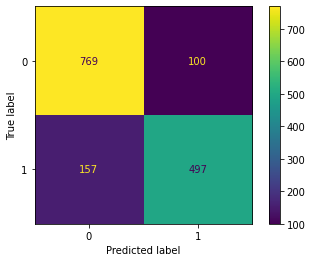

{'accuracy': 0.8312541037426132, 'f1': 0.825694430528001}

In [ ]:
trainer_ernie = train("nghuyong/ernie-2.0-base-en", "nghuyong/ernie-2.0-base-en", "trained_sentiment_ernie", X_train, y_train)
preds_ernie = predict_and_calculate_score("nghuyong/ernie-2.0-base-en", trainer_ernie, X_test, y_test)
preds_ernie